In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
file_path = 'Customer_Churn_Data_Large.xlsx'

# Load all sheets into a dictionary of DataFrames
excel_data = pd.read_excel(file_path, sheet_name=None)


sheet_names = excel_data.keys()
print("Sheet names:", sheet_names)


for sheet_name, df in excel_data.items():
    print(f"Data from {sheet_name}:")
    print(df.head(), "\n")


Sheet names: dict_keys(['Customer_Demographics', 'Transaction_History', 'Customer_Service', 'Online_Activity', 'Churn_Status'])
Data from Customer_Demographics:
   CustomerID  Age Gender MaritalStatus IncomeLevel
0           1   62      M        Single         Low
1           2   65      M       Married         Low
2           3   18      M        Single         Low
3           4   21      M       Widowed         Low
4           5   21      M      Divorced      Medium 

Data from Transaction_History:
   CustomerID  TransactionID TransactionDate  AmountSpent ProductCategory
0           1           7194      2022-03-27       416.50     Electronics
1           2           7250      2022-08-08        54.96        Clothing
2           2           9660      2022-07-25       197.50     Electronics
3           2           2998      2022-01-25       101.31       Furniture
4           2           1228      2022-07-24       397.37        Clothing 

Data from Customer_Service:
   CustomerID  Inter

In [4]:
df_demographics = excel_data['Customer_Demographics'][["CustomerID","Age","Gender","MaritalStatus","IncomeLevel"]]
df_custumor_Service= excel_data['Customer_Service'][['CustomerID', 'InteractionType', 'ResolutionStatus']]
df_Transaction= excel_data['Transaction_History'][['CustomerID', 'AmountSpent', 'ProductCategory']]
df_cust_online= excel_data['Online_Activity'][['CustomerID', 'LoginFrequency', 'ServiceUsage']]
df_churn_status= excel_data['Churn_Status'][['CustomerID', 'ChurnStatus']]

In [5]:
merge_data=df_demographics.merge(df_Transaction, on='CustomerID').merge(df_custumor_Service,on='CustomerID').merge(df_cust_online,on='CustomerID').merge(df_cust_online,on="CustomerID").merge(df_churn_status,on="CustomerID")
merge_data.head()

,CustomerID,Age,Gender,MaritalStatus,IncomeLevel,AmountSpent,ProductCategory,InteractionType,ResolutionStatus,LoginFrequency_x,ServiceUsage_x,LoginFrequency_y,ServiceUsage_y,ChurnStatus
0,1,62,M,Single,Low,416.50,Electronics,Inquiry,Resolved,34,Mobile App,34,Mobile App,0
1,2,65,M,Married,Low,54.96,Clothing,Inquiry,Resolved,5,Website,5,Website,1
2,2,65,M,Married,Low,197.50,Electronics,Inquiry,Resolved,5,Website,5,Website,1
3,2,65,M,Married,Low,101.31,Furniture,Inquiry,Resolved,5,Website,5,Website,1
4,2,65,M,Married,Low,397.37,Clothing,Inquiry,Resolved,5,Website,5,Website,1


In [6]:
#checking Null Vlaues
merge_data.isnull().sum()

CustomerID          0
Age                 0
Gender              0
MaritalStatus       0
IncomeLevel         0
AmountSpent         0
ProductCategory     0
InteractionType     0
ResolutionStatus    0
LoginFrequency_x    0
ServiceUsage_x      0
LoginFrequency_y    0
ServiceUsage_y      0
ChurnStatus         0
dtype: int64

In [10]:
merge_data.to_csv('customer_churn.csv', index=False)


In [7]:
numeric_columns = merge_data.select_dtypes(include=[np.number]).columns

def detect_outliers_iqr(df):
    outliers = pd.DataFrame(index=df.index)
    for column in numeric_columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        is_outlier = (df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))
        outliers[column] = is_outlier
    return outliers.any(axis=1)

outliers_iqr = detect_outliers_iqr(merge_data)
print(f"Number of outlier rows detected by IQR method: {outliers_iqr.sum()}")

# Optionally, display rows that are considered outliers
outlier_rows = merge_data[outliers_iqr]
print("Outlier rows:")
print(outlier_rows)

Number of outlier rows detected by IQR method: 1072
Outlier rows:
      CustomerID  Age Gender MaritalStatus IncomeLevel  AmountSpent  \
1              2   65      M       Married         Low        54.96   
2              2   65      M       Married         Low       197.50   
3              2   65      M       Married         Low       101.31   
4              2   65      M       Married         Low       397.37   
5              2   65      M       Married         Low       285.21   
...          ...  ...    ...           ...         ...          ...   
5199         995   23      F      Divorced         Low       225.82   
5200         995   23      F      Divorced         Low       494.90   
5201         995   23      F      Divorced         Low       101.21   
5202         995   23      F      Divorced         Low        73.91   
5203         995   23      F      Divorced         Low       124.16   

     ProductCategory InteractionType ResolutionStatus  LoginFrequency_x  \
1     

In [90]:
from scipy import stats

# Calculate Z-scores
z_scores = np.abs(stats.zscore(merge_data[numeric_columns]))
outliers_z = (z_scores > 3).any(axis=1)
print(f"Number of outlier rows detected by Z-Score method: {outliers_z.sum()}")

# Display outlier rows
outlier_rows_z = merge_data[outliers_z]
print("Outlier rows (Z-Score method):")
print(outlier_rows_z)


Number of outlier rows detected by Z-Score method: 0
Outlier rows (Z-Score method):
Empty DataFrame
Columns: [CustomerID, Age, Gender, MaritalStatus, IncomeLevel, AmountSpent, ProductCategory, InteractionType, ResolutionStatus, LoginFrequency_x, ServiceUsage_x, LoginFrequency_y, ServiceUsage_y, ChurnStatus]
Index: []


In [91]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Select numeric columns excluding 'ChurnStatus'
numeric_columns = merge_data.select_dtypes(include=[np.number]).columns.drop('ChurnStatus')

# Initialize the scaler
scaler = StandardScaler()

# Standardize numeric columns (excluding the target variable)
merge_data[numeric_columns] = scaler.fit_transform(merge_data[numeric_columns])


In [92]:
print(merge_data['ChurnStatus'].head())  # Check if ChurnStatus remains 0 or 1


0    0
1    1
2    1
3    1
4    1
Name: ChurnStatus, dtype: int64


In [93]:
categorical_columns = ['Gender', 'MaritalStatus', 'ProductCategory', 'InteractionType', 'ResolutionStatus','IncomeLevel','ServiceUsage_x','ServiceUsage_y']


In [94]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_features = encoder.fit_transform(merge_data[categorical_columns])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))

# Combine with original dataframe
merge_data_encoded = merge_data.drop(columns=categorical_columns).join(encoded_df)

# Identify and convert boolean columns
bool_columns = merge_data_encoded.select_dtypes(include=['bool']).columns
merge_data_encoded[bool_columns] = merge_data_encoded[bool_columns].astype(int)

merge_data_encoded

,CustomerID,Age,AmountSpent,LoginFrequency_x,LoginFrequency_y,ChurnStatus,Gender_M,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widowed,...,ProductCategory_Groceries,InteractionType_Feedback,InteractionType_Inquiry,ResolutionStatus_Unresolved,IncomeLevel_Low,IncomeLevel_Medium,ServiceUsage_x_Online Banking,ServiceUsage_x_Website,ServiceUsage_y_Online Banking,ServiceUsage_y_Website
0,-1.728463,1.222379,1.131382,0.572791,0.572791,0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-1.724975,1.416820,-1.391297,-1.482595,-1.482595,1,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2,-1.724975,1.416820,-0.396711,-1.482595,-1.482595,1,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,-1.724975,1.416820,-1.067885,-1.482595,-1.482595,1,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,-1.724975,1.416820,0.997901,-1.482595,-1.482595,1,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5199,1.739135,-1.305351,-0.199105,0.572791,0.572791,1,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
5200,1.739135,-1.305351,1.678426,0.572791,0.572791,1,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
5201,1.739135,-1.305351,-1.068583,0.572791,0.572791,1,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
5202,1.739135,-1.305351,-1.259071,0.572791,0.572791,1,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


In [95]:
from sklearn.model_selection import train_test_split
X=merge_data_encoded.drop(columns=['ChurnStatus', 'CustomerID']) 
Y=merge_data_encoded["ChurnStatus"]

x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=42)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((3642, 21), (1562, 21), (3642,), (1562,))

Cross-validation scores: [0.80883766 0.78097983 0.80019212 0.79731028 0.77211538]
Mean cross-validation accuracy: 0.7918870538683219
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.9700722802574655
Accuracy: 0.9795134443021767
Confusion Matrix:
[[1234    2]
 [  30  296]]
Precision: 0.9932885906040269
Recall: 0.9079754601226994
F1-Score: 0.9487179487179487
ROC-AUC: 0.992074423729823


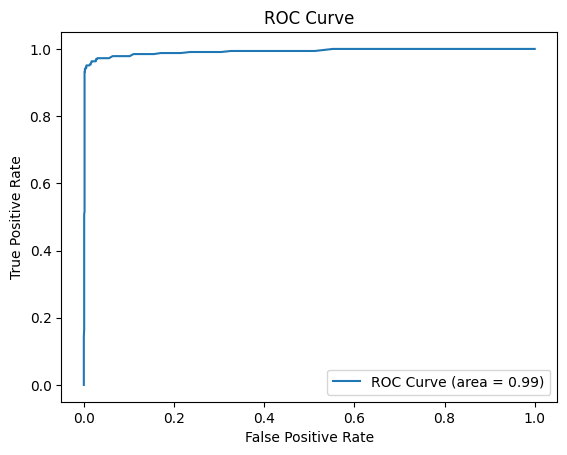

In [98]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score

rf_model = RandomForestClassifier(random_state=42)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(rf_model, X, Y, cv=5, scoring='accuracy')
print(f'Cross-validation scores: {cv_scores}')
print(f'Mean cross-validation accuracy: {cv_scores.mean()}')

# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(x_train, y_train)

# Best parameters and best score
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best cross-validation score: {grid_search.best_score_}')

# Train the model with the best parameters
best_rf_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_rf_model.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, best_rf_model.predict_proba(x_test)[:, 1])

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')
print(f'ROC-AUC: {roc_auc}')

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, best_rf_model.predict_proba(x_test)[:, 1])
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
rf_model= RandomForestClassifier(random_state=42)
rf_model.fit(x_train,y_train)
y_pred=rf_model.predict(x_test)